In [241]:
import torch
%matplotlib inline
from matplotlib import pyplot
import tqdm
from sklearn import metrics

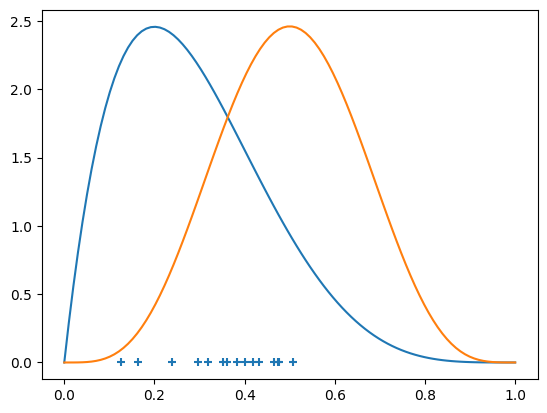

In [109]:
dist_x = torch.distributions.Beta(2, 5)
dist_y = torch.distributions.Beta(5, 5)
x = dist_x.sample((15,))
y = dist_y.sample((15,))
z = torch.linspace(0.0, 1.0, 100)
pyplot.scatter(x, torch.zeros_like(x), marker='+')
raw_density_x = dist_x.log_prob(z).exp()
raw_density_y = dist_y.log_prob(z).exp()
density_x = torch.where(raw_density_x.isnan(), torch.tensor(0.0), raw_density_x)
density_y = torch.where(raw_density_y.isnan(), torch.tensor(0.0), raw_density_y)
pyplot.plot(z, density_x)
pyplot.plot(z, density_y)

In [111]:
x.shape

torch.Size([15])

In [4]:
def mmd(x, y, sigma):
    # compare kernel MMD paper and code:
    # A. Gretton et al.: A kernel two-sample test, JMLR 13 (2012)
    # http://www.gatsby.ucl.ac.uk/~gretton/mmd/mmd.htm
    # x shape [n, d] y shape [m, d]
    # n_perm number of bootstrap permutations to get p-value, pass none to not get p-value
    n, d = x.shape
    m, d2 = y.shape
    assert d == d2
    xy = torch.cat([x.detach(), y.detach()], dim=0)
    dists = torch.cdist(xy, xy, p=2.0)
    # we are a bit sloppy here as we just keep the diagonal and everything twice
    # note that sigma should be squared in the RBF to match the Gretton et al heuristic
    k = torch.exp((-1/(2*sigma**2)) * dists**2) + torch.eye(n+m)*1e-5
    k_x = k[:n, :n]
    k_y = k[n:, n:]
    k_xy = k[:n, n:]
    # The diagonals are always 1 (up to numerical error, this is (3) in Gretton et al.)
    # note that their code uses the biased (and differently scaled mmd)
    mmd = k_x.sum() / (n * (n - 1)) + k_y.sum() / (m * (m - 1)) - 2 * k_xy.sum() / (n * m)
    return mmd

# MMD as two dimensional distance metric

In [170]:
def MMD(x, y, kernel):
    """Emprical maximum mean discrepancy. The lower the result
       the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))
    
    dxx = rx.t() + rx - 2. * xx # Used for A in (1)
    dyy = ry.t() + ry - 2. * yy # Used for B in (1)
    dxy = rx.t() + ry - 2. * zz # Used for C in (1)
    
    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))
    
    if kernel == "multiscale":
        
        bandwidth_range = [0.2, 0.5, 0.9, 1.3]
        for a in bandwidth_range:
            XX += a**2 * (a**2 + dxx)**-1
            YY += a**2 * (a**2 + dyy)**-1
            XY += a**2 * (a**2 + dxy)**-1
            
    if kernel == "rbf":
      
        bandwidth_range = [10, 15, 20, 50]
        for a in bandwidth_range:
            XX += torch.exp(-0.5*dxx/a)
            YY += torch.exp(-0.5*dyy/a)
            XY += torch.exp(-0.5*dxy/a)
      
      

    return torch.mean(XX + YY - 2. * XY)

In [239]:
def mmd_rbf(X, Y, gamma=1.0):
    """MMD using rbf (gaussian) kernel (i.e., k(x,y) = exp(-gamma * ||x-y||^2 / 2))

    Arguments:
        X {[n_sample1, dim]} -- [X matrix]
        Y {[n_sample2, dim]} -- [Y matrix]

    Keyword Arguments:
        gamma {float} -- [kernel parameter] (default: {1.0})

    Returns:
        [scalar] -- [MMD value]
    """
    XX = metrics.pairwise.rbf_kernel(X, X, gamma)
    YY = metrics.pairwise.rbf_kernel(Y, Y, gamma)
    XY = metrics.pairwise.rbf_kernel(X, Y, gamma)
    return XX.mean() + YY.mean() - 2 * XY.mean()


def mmd_poly(X, Y, degree=2, gamma=1, coef0=0):
    """MMD using polynomial kernel (i.e., k(x,y) = (gamma <X, Y> + coef0)^degree)

    Arguments:
        X {[n_sample1, dim]} -- [X matrix]
        Y {[n_sample2, dim]} -- [Y matrix]

    Keyword Arguments:
        degree {int} -- [degree] (default: {2})
        gamma {int} -- [gamma] (default: {1})
        coef0 {int} -- [constant item] (default: {0})

    Returns:
        [scalar] -- [MMD value]
    """
    XX = metrics.pairwise.polynomial_kernel(X, X, degree, gamma, coef0)
    YY = metrics.pairwise.polynomial_kernel(Y, Y, degree, gamma, coef0)
    XY = metrics.pairwise.polynomial_kernel(X, Y, degree, gamma, coef0)
    return XX.mean() + YY.mean() - 2 * XY.mean()

In [259]:
X = torch.rand(17,17)
Y = torch.rand(17,17)

# X = torch.ones(2,4)
# Y = torch.ones(2,4)

# print(X)
# print(Y)

print(mmd(X,Y,1))
device = 'cpu'
# print(MMD(X,Y,kernel='rbf'))
print(mmd_rbf(X,Y))
# print(MMD(X,Y,kernel='multiscale'))
# print(mmd_poly(X,Y))

tensor(0.1395)
0.11520044505596161
